In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from lstm_class import Lstm
from sklearn.metrics import mean_squared_error

# import helper functions
from helper import create_df_per_stock
from helper import prepare_data
from helper import check_existing_results
from helper import run_hyperparameter_tuning
from helper import train_and_evaluate_best_model
from helper import run_for_stocks

# Load Dataset

In [2]:
std_stocks = pd.read_csv("../data/stock_standard_1.csv").iloc[:, 3:] # Drop the First Three Columns
std_stocks = std_stocks.sort_values(by=['tic', 'datadate']) # Sort by Ticker and then Date
std_stocks.drop(columns=['conm', 'gsector'], inplace=True) # Drop Company Name and GICS Sector
std_stocks.reset_index(inplace=True) # Reset the Index
tickers = std_stocks['tic'].unique() # Create a List of the Unique Stock Tickers
std_stocks.head()

,index,datadate,tic,cshtrm,prccm,prchm,prclm,trt1m,CAPEI,evm,...,high_low_ratio,RSI_14,MA_3,price_to_MA_3,return_momentum_6m,MA_6,return_momentum_9m,MA_9,return_momentum_12m,MA_12
0,22,2011-03-31,AMZN,0.057669,0.050441,0.047726,0.048270,0.449252,0.657229,0.104348,...,0.020950,0.599129,0.050675,0.673276,0.278596,0.050655,0.346955,0.046881,0.203680,0.044979
1,64,2011-04-30,AMZN,0.055855,0.054863,0.052030,0.052741,0.479247,0.657454,0.104348,...,0.020388,0.647066,0.053232,0.698572,0.291211,0.052154,0.350194,0.049443,0.222852,0.046454
2,106,2011-05-31,AMZN,0.051408,0.055111,0.054307,0.057432,0.427200,0.657571,0.104227,...,0.010842,0.669937,0.055518,0.671418,0.270170,0.053198,0.327768,0.051806,0.249207,0.048244
3,148,2011-06-30,AMZN,0.046094,0.057310,0.054270,0.054622,0.449368,0.657700,0.104227,...,0.022005,0.668990,0.057899,0.669438,0.275018,0.054399,0.255807,0.053366,0.306600,0.050637
4,190,2011-07-31,AMZN,0.044648,0.062395,0.059825,0.061283,0.479955,0.657969,0.104227,...,0.017924,0.721217,0.060509,0.699107,0.333047,0.056992,0.267572,0.055250,0.309609,0.053266


In [3]:
# Dictionary to hold dataframe for each stock
df_per_stock = create_df_per_stock(tickers=tickers,
                                   dataframe=std_stocks)

/Users/talhajamal/Documents/Imperial/Courses/Semester 3/Big Data 2/BDF2/Coursework2/src/helper.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trt1m'] = df['trt1m'].shift(-1) # Shift Target Return up


# Run for All Stocks

In [6]:
# Test with small list
param_grid = {
    'lstm_units': [100, 150],
    'dense_units1': [50, 100, 150],
    'dense_units2': [50, 75],
    'batch_size': [32, 64],
    'optimizer': ['adam']
}
models = run_for_stocks(['AMZN'], df_per_stock, param_grid)

Processing stock: AMZN
Results already exist for AMZN. Loading existing results.
Training and evaluating the best model for AMZN.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0735 - mse: 0.0735
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - mse: 0.0055 
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - mse: 0.0038
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mse: 0.0029
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - mse: 0.0027
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - mse: 0.0030
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mse: 0.0029
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mse: 0.0030
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - mse: 0.0029
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - mse: 0.0027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
For Stock AMZN the MSE is 0.004462980133845277
Pred

# Use below Data for Presentation Slides

In [4]:
# Lets first try to get the model to run for 1 stock
amzn = df_per_stock['AMZN'].iloc[:, 1:]
y = amzn['trt1m'].values
amzn.drop(columns=['trt1m'], inplace=True)
X = amzn.iloc[:, 2:].values
print(f"The Shape of X Features is: {X.shape}")
print(f"The Shape of y Features is: {y.shape}")

The Shape of X Features is: (153, 63)
The Shape of y Features is: (153,)


In [5]:
sequence_length = 12 # Feed past 12 month returns into sequence for LSTM
# Converting Features into 3D space for LSTM to add a time component
X_features, y_target = [], []
for i in range(X.shape[0] - sequence_length):
    X_features.append(X[i:i+sequence_length])
    y_target.append(y[i + sequence_length])
X_features = np.array(X_features)
y_target = np.array(y_target)

In [6]:
print(f"The Shape of X Features is: {X_features.shape}")
print(f"The Shape of y Features is: {y_target.shape}")

The Shape of X Features is: (141, 12, 63)
The Shape of y Features is: (141,)


In [7]:
train_size = int(len(amzn) * 0.8)
print(f"The size of my training set will be : {train_size} and the test set will be : {int(len(amzn)) - train_size}")
X_train, y_train = X_features[:train_size], y_target[:train_size]
y_train.reshape(-1, 1)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
X_test, y_test = X_features[train_size:], y_target[train_size:]
y_target.reshape(-1, 1)
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

The size of my training set will be : 122 and the test set will be : 31
Shape of X_train: (122, 12, 63)
Shape of y_train: (122,)
Shape of X_test: (19, 12, 63)
Shape of y_test: (19,)


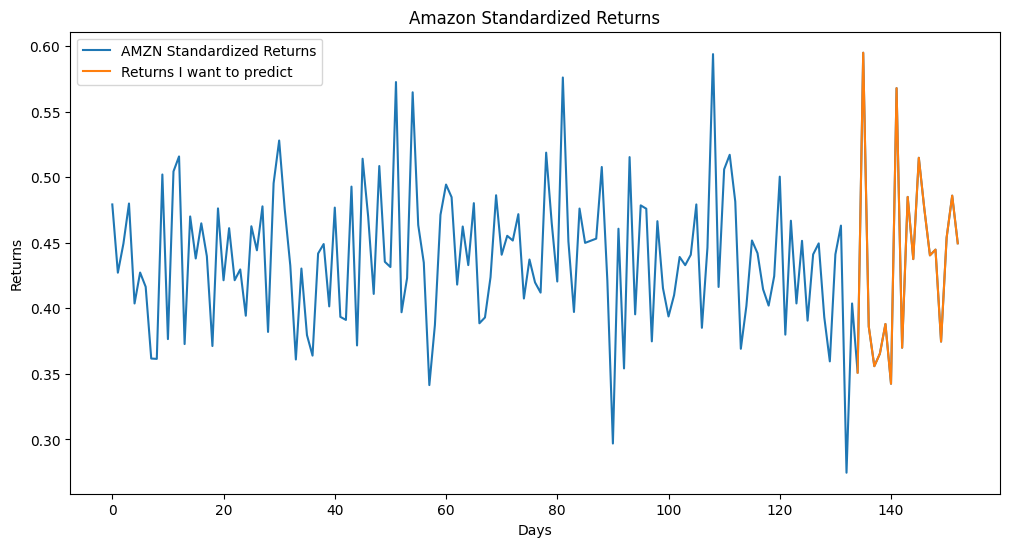

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df_per_stock['AMZN']['trt1m'], label='AMZN Standardized Returns')
plt.plot(df_per_stock['AMZN']['trt1m'][-19:], label='Returns I want to predict')
plt.title(f'Amazon Standardized Returns')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.legend()
plt.show()

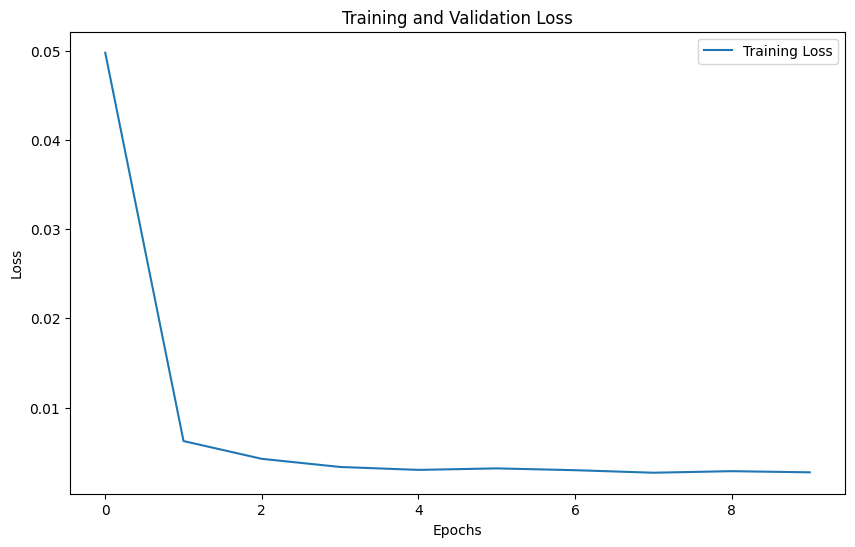

In [7]:
models['AMZN'].plot_performance()